
# ANALYSIS <!-- testing a lot of stuff -->

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
file_path = '../airflow/data/production/flights.csv'
df = pd.read_csv(file_path)
df.head()

,id,scheduled_time,departure_icao,arrival_icao,delay_in_minutes,flight_status,airline,flight_number,departure_wind,departure_visibility,departure_sky_condition,departure_temperature,departure_altimeter,destination_wind,destination_visibility,destination_sky_condition,destination_temperature,destination_altimeter
0,76,2025-01-09T17:30:00.000,kmco,kfll,17,active,spirit airlines,359,01013G18KT,10SM,CLR,10/M01,3023.0,34011KT,10SM,FEW040,14/M02,3016.0
1,78,2025-01-09T12:30:00.000,kmco,kfll,17,active,netjets aviation,776,32007KT,10SM,CLR,03/M03,3020.0,33007KT,10SM,FEW045,08/02,3011.0
2,79,2025-01-09T17:00:00.000,kmco,kfll,48,active,fly alliance,129,01013G18KT,10SM,CLR,10/M01,3023.0,34011KT,10SM,FEW040,14/M02,3016.0
3,2,2025-01-01T06:25:00.000,kmco,kfll,12,active,spirit airlines,195,22005KT,10SM,FEW025,19/18,2999.0,23004KT,10SM,FEW250,23/21,3000.0
4,3,2025-01-01T16:15:00.000,kmco,kfll,15,active,southwest airlines,4665,02005KT,10SM,FEW020,18/14,3012.0,31006KT,10SM,BKN008,20/19,3004.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         151 non-null    int64  
 1   scheduled_time             151 non-null    object 
 2   departure_icao             151 non-null    object 
 3   arrival_icao               151 non-null    object 
 4   delay_in_minutes           151 non-null    int64  
 5   flight_status              151 non-null    object 
 6   airline                    151 non-null    object 
 7   flight_number              151 non-null    int64  
 8   departure_wind             151 non-null    object 
 9   departure_visibility       151 non-null    object 
 10  departure_sky_condition    151 non-null    object 
 11  departure_temperature      151 non-null    object 
 12  departure_altimeter        150 non-null    float64
 13  destination_wind           151 non-null    object 

C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\558016399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_delays.index, y=airline_delays.values, palette='viridis')


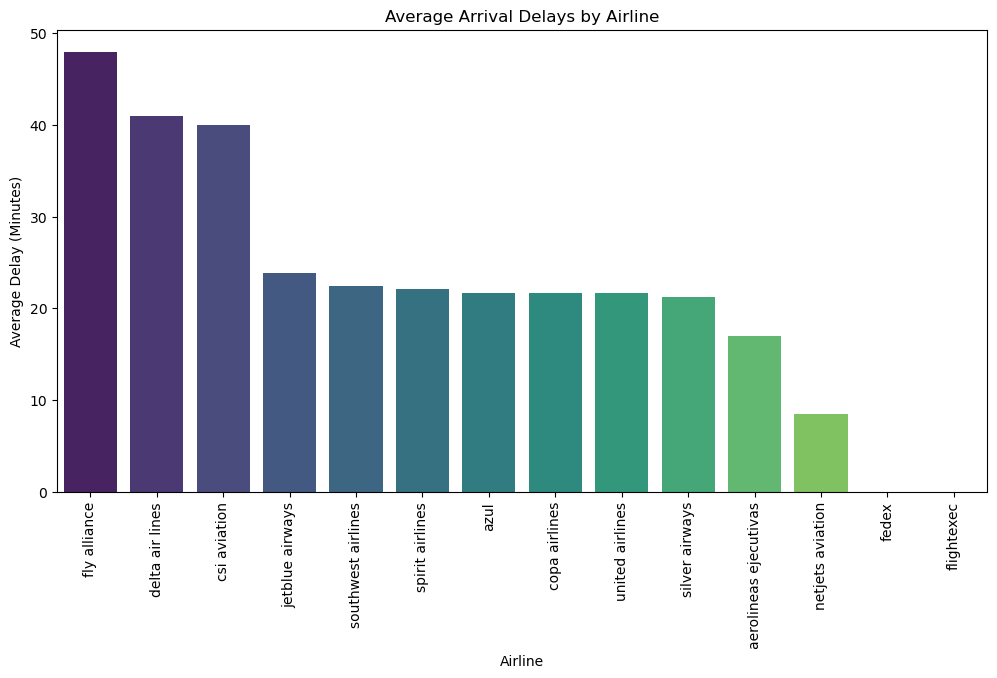

In [26]:
# Group by airline and calculate mean delays
airline_delays = df.groupby('airline')['delay_in_minutes'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_delays.index, y=airline_delays.values, palette='viridis')
plt.title('Average Arrival Delays by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=90)
plt.show()

In [27]:
import re

# Function to determine if the wind is strong (e.g., > 30 knots)
def is_strong_wind(wind):
    match = re.search(r'(\d{2})', wind)  # Find the first two digits (wind speed in knots)
    if match:
        wind_speed = int(match.group(1))
        return wind_speed > 30
    return False

# Function to check visibility (e.g., < 3 statute miles)
def is_low_visibility(visibility):
    if 'SM' in visibility:
        visibility_value = float(visibility.replace('SM', ''))
        return visibility_value < 3
    return False

# Function to check if sky condition is bad (BKN, OVC, TCU, CB)
def is_bad_sky_condition(sky_condition):
    if any(condition in sky_condition for condition in ['BKN', 'OVC', 'TCU', 'CB']):
        return True
    return False


# Function to check if the temperature is extreme (e.g., below -5°C or above 40°C)
def is_extreme_temperature(temperature):
    match = re.match(r'(\d+)', temperature.split('/')[0])  # Extract temperature from format like "07/02"
    if match:
        temp = int(match.group(1))
        return temp < -5 or temp > 40
    return False

# Now we apply these functions to create a 'BadWeatherDeparture' column
def determine_bad_weather_departure(weather_row):
    wind, visibility, sky_condition, temperature = weather_row
    if (is_strong_wind(wind) or 
        is_low_visibility(visibility) or 
        is_bad_sky_condition(sky_condition) or 
        is_extreme_temperature(temperature)):
        return 1  # Bad weather
    return 0  # Good weather


C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\1194231609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BadWeatherDeparture', y='delay_in_minutes', data=df_departure, palette='coolwarm')


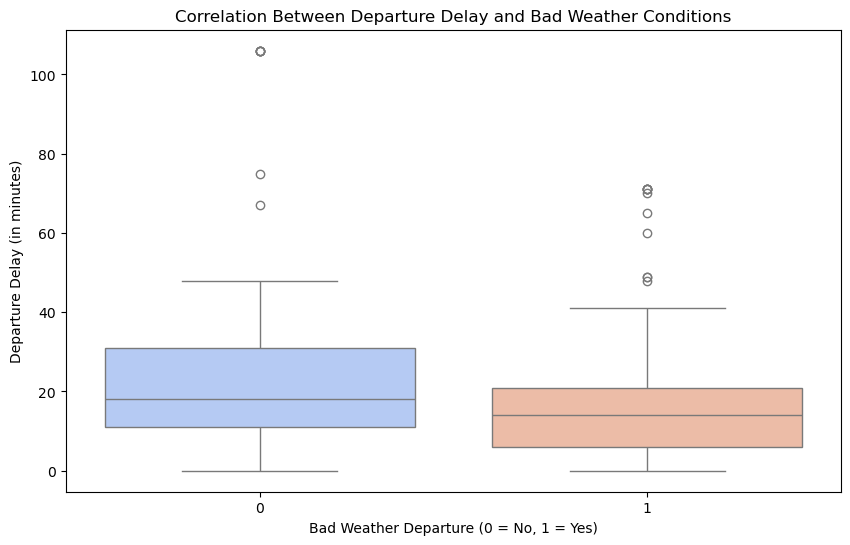

In [28]:
df_departure = df

# Apply the function to the 'WeatherDeparture' column
df_departure['BadWeatherDeparture'] = df_departure[['departure_wind', 'departure_visibility', 'departure_sky_condition', 'departure_temperature']].apply(determine_bad_weather_departure, axis=1)

df_departure = df_departure.dropna(subset=['delay_in_minutes', 'BadWeatherDeparture'])

# Create a scatter plot to show the correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='BadWeatherDeparture', y='delay_in_minutes', data=df_departure, palette='coolwarm')

# Set plot title and labels
plt.title('Correlation Between Departure Delay and Bad Weather Conditions')
plt.xlabel('Bad Weather Departure (0 = No, 1 = Yes)')
plt.ylabel('Departure Delay (in minutes)')

# Show plot
plt.show()

C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\3011454321.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='BadWeatherDestination', y='delay_in_minutes', data=df_destination, palette='coolwarm')


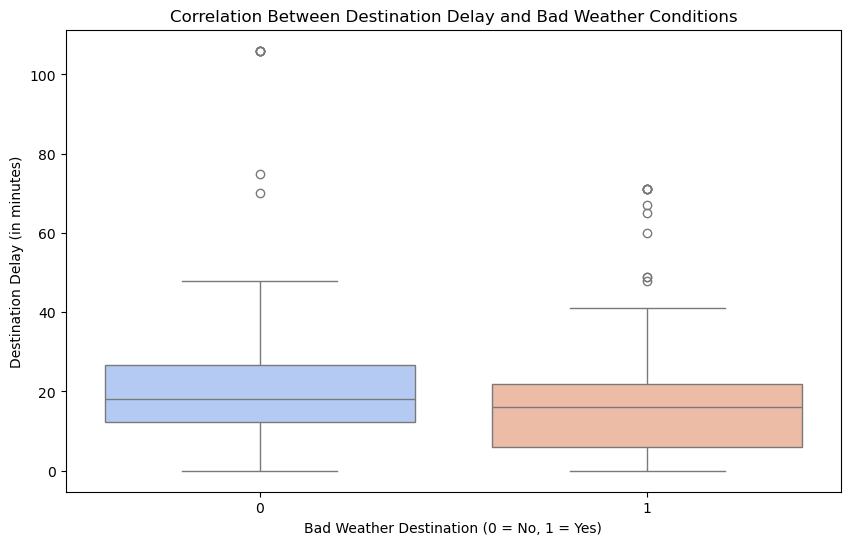

In [29]:
df_destination = df

# Apply the function to the 'WeatherDeparture' column
df_destination['BadWeatherDestination'] = df_destination[['destination_wind', 'destination_visibility', 'departure_sky_condition', 'departure_temperature']].apply(determine_bad_weather_departure, axis=1)

df_destination = df_destination.dropna(subset=['delay_in_minutes', 'BadWeatherDestination'])

# Create a scatter plot to show the correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='BadWeatherDestination', y='delay_in_minutes', data=df_destination, palette='coolwarm')

# Set plot title and labels
plt.title('Correlation Between Destination Delay and Bad Weather Conditions')
plt.xlabel('Bad Weather Destination (0 = No, 1 = Yes)')
plt.ylabel('Destination Delay (in minutes)')

# Show plot
plt.show()

In [30]:
# Create a new column for BadWeather at either departure or destination (logical OR)
df['BadWeatherEither'] = df['BadWeatherDeparture'] | df['BadWeatherDestination']

C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\1039127426.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_period_delays.index, y=time_period_delays.values, palette='coolwarm')


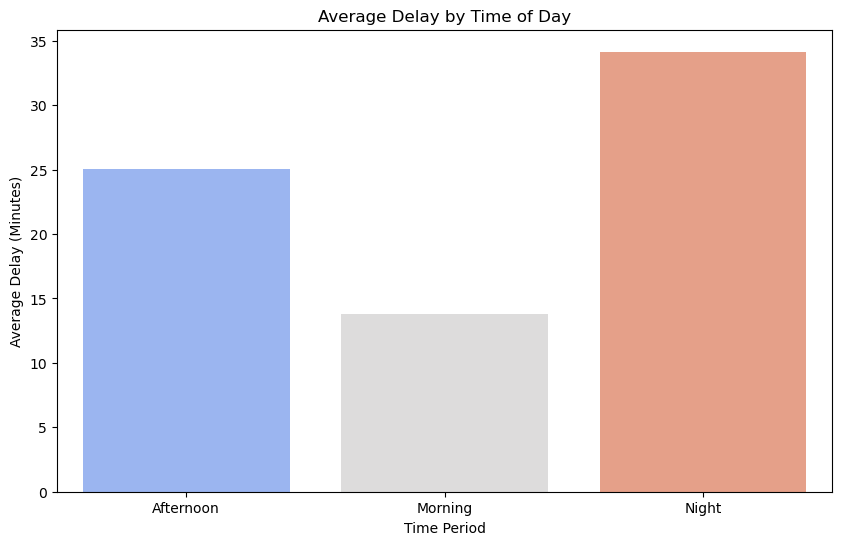

In [31]:
# Analyze by time of the day

# Extract hour from the scheduled_time
df['hour'] = pd.to_datetime(df['scheduled_time']).dt.hour

# Create time periods
def get_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(get_time_period)

# Group by time period and calculate average delay
time_period_delays = df.groupby('time_period')['delay_in_minutes'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=time_period_delays.index, y=time_period_delays.values, palette='coolwarm')
plt.title('Average Delay by Time of Day')
plt.xlabel('Time Period')
plt.ylabel('Average Delay (Minutes)')
plt.show()


In [32]:
# which weather factor has the most impact?

# Create separate columns for each weather condition
df['StrongWindDeparture'] = df['departure_wind'].apply(is_strong_wind)
df['LowVisibilityDeparture'] = df['departure_visibility'].apply(is_low_visibility)
df['BadSkyConditionDeparture'] = df['departure_sky_condition'].apply(is_bad_sky_condition)
df['ExtremeTemperatureDeparture'] = df['departure_temperature'].apply(is_extreme_temperature)

# Calculate average delays for each weather condition
weather_impact = df.groupby(['StrongWindDeparture', 'LowVisibilityDeparture', 'BadSkyConditionDeparture', 'ExtremeTemperatureDeparture'])['delay_in_minutes'].mean()

# Print the result
print(weather_impact)


StrongWindDeparture  LowVisibilityDeparture  BadSkyConditionDeparture  ExtremeTemperatureDeparture
False                False                   False                     False                          30.200000
                                             True                      False                          40.500000
True                 False                   False                     False                          15.470588
                                             True                      False                          15.166667
Name: delay_in_minutes, dtype: float64


C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\268994103.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=both_ends_delay.index, y=both_ends_delay.values, palette='coolwarm')


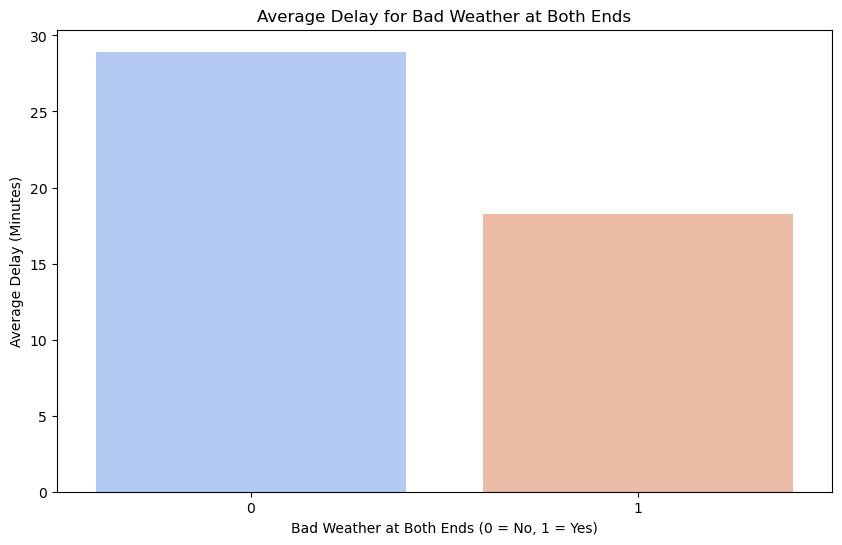

In [33]:
# Check the Correlation Between Departure and Destination Weather

# Create a new column for bad weather at both ends
df['BadWeatherBothEnds'] = (df['BadWeatherDeparture'] & df['BadWeatherDestination']).astype(int)

# Group by BadWeatherBothEnds and calculate average delay
both_ends_delay = df.groupby('BadWeatherBothEnds')['delay_in_minutes'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=both_ends_delay.index, y=both_ends_delay.values, palette='coolwarm')
plt.title('Average Delay for Bad Weather at Both Ends')
plt.xlabel('Bad Weather at Both Ends (0 = No, 1 = Yes)')
plt.ylabel('Average Delay (Minutes)')
plt.show()

In [34]:
# Create separate columns for each weather condition at the destination
df['StrongWindDestination'] = df['destination_wind'].apply(is_strong_wind)
df['LowVisibilityDestination'] = df['destination_visibility'].apply(is_low_visibility)
df['BadSkyConditionDestination'] = df['destination_sky_condition'].apply(is_bad_sky_condition)
df['ExtremeTemperatureDestination'] = df['destination_temperature'].apply(is_extreme_temperature)

In [35]:
# Compare Short Delays vs. Long Delays (Threshold Analysis)

# Create a new column for delay categories
def categorize_delay(delay):
    if delay <= 15:
        return 'Short Delay'
    elif 15 < delay <= 30:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

df['delay_category'] = df['delay_in_minutes'].apply(categorize_delay)

# Group by delay category and calculate average weather conditions
delay_weather = df.groupby('delay_category')[['StrongWindDeparture', 'LowVisibilityDeparture', 'BadSkyConditionDeparture', 'ExtremeTemperatureDeparture']].mean()

# Print the result
print(delay_weather)



                StrongWindDeparture  LowVisibilityDeparture  \
delay_category                                                
Long Delay                 0.354839                     0.0   
Moderate Delay             0.608696                     0.0   
Short Delay                0.716216                     0.0   

                BadSkyConditionDeparture  ExtremeTemperatureDeparture  
delay_category                                                         
Long Delay                      0.322581                          0.0  
Moderate Delay                  0.260870                          0.0  
Short Delay                     0.216216                          0.0  


In [36]:
# Create separate columns for each weather condition at the destination
df['StrongWindDestination'] = df['destination_wind'].apply(is_strong_wind)
df['LowVisibilityDestination'] = df['destination_visibility'].apply(is_low_visibility)
df['BadSkyConditionDestination'] = df['destination_sky_condition'].apply(is_bad_sky_condition)
df['ExtremeTemperatureDestination'] = df['destination_temperature'].apply(is_extreme_temperature)


In [37]:
# Count how often each extreme weather condition is true for both departure and destination
weather_counts = df[['StrongWindDeparture', 'LowVisibilityDeparture', 'BadSkyConditionDeparture', 'ExtremeTemperatureDeparture', 'StrongWindDestination', 'LowVisibilityDestination', 'BadSkyConditionDestination', 'ExtremeTemperatureDestination']].sum()

# Display the counts
print(weather_counts)


StrongWindDeparture              92
LowVisibilityDeparture            0
BadSkyConditionDeparture         38
ExtremeTemperatureDeparture       0
StrongWindDestination            91
LowVisibilityDestination          0
BadSkyConditionDestination       41
ExtremeTemperatureDestination     0
dtype: int64


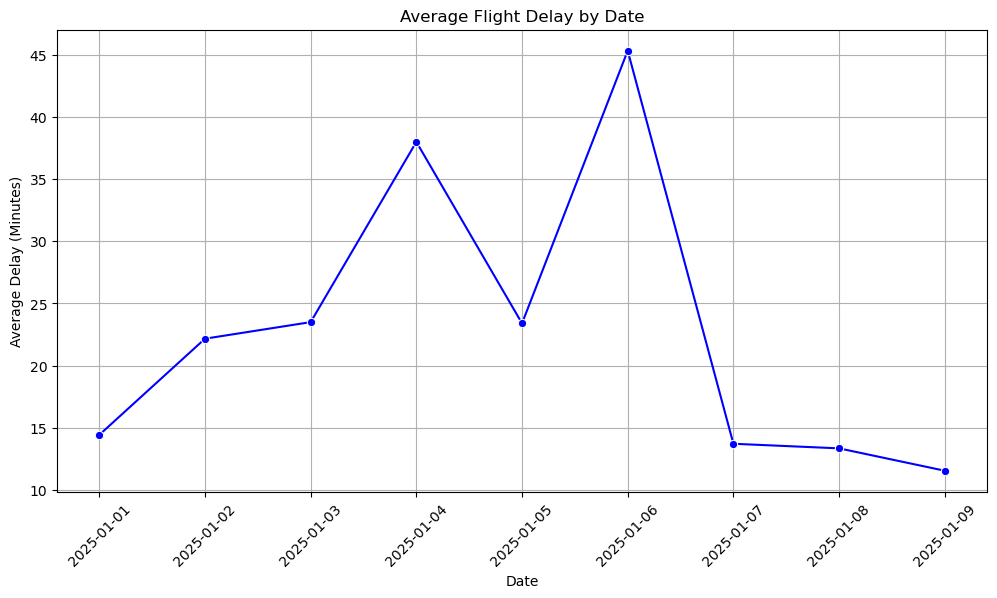

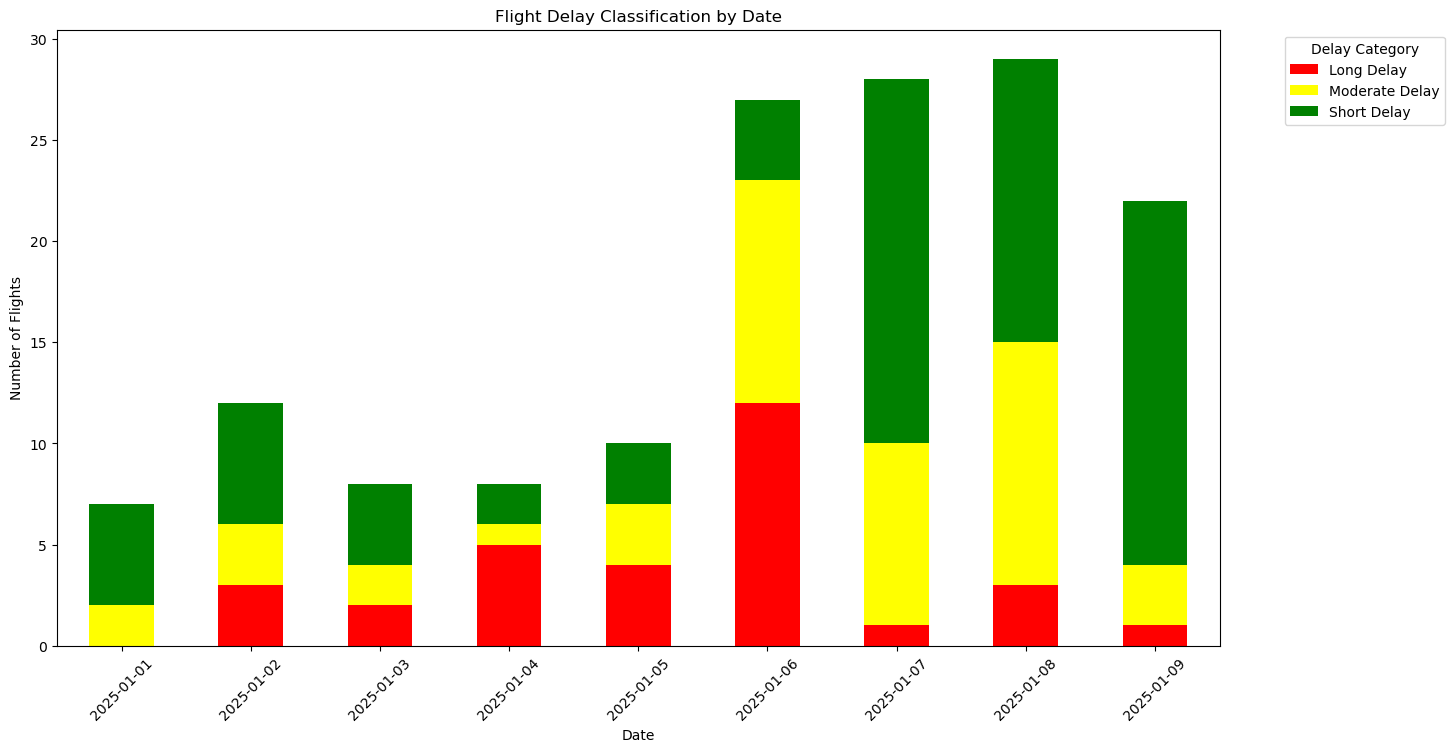

In [38]:
# Convert 'scheduled_time' to datetime format
df['scheduled_time'] = pd.to_datetime(df['scheduled_time'])

# Extract the date
df['date'] = df['scheduled_time'].dt.date

# Group by date and calculate average delay
delays_by_date = df.groupby('date')['delay_in_minutes'].mean()

# Plot the delays by date
plt.figure(figsize=(12, 6))
sns.lineplot(x=delays_by_date.index, y=delays_by_date.values, marker='o', color='b')
plt.title('Average Flight Delay by Date')
plt.xlabel('Date')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Classify delays into categories by date
def classify_delay(delay):
    if delay <= 15:
        return 'Short Delay'
    elif 15 < delay <= 30:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

# Apply the classification to create a new column
df['delay_category'] = df['delay_in_minutes'].apply(classify_delay)

# Group by date and delay category
delays_by_date_category = df.groupby(['date', 'delay_category']).size().unstack(fill_value=0)

# Plot the results with intuitive colors
delays_by_date_category.plot(kind='bar', stacked=True, figsize=(15, 8), 
                             color=['red', 'yellow', 'green'])
plt.title('Flight Delay Classification by Date')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Delay Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\374512729.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='BadWeatherDeparture', y='NormalizedDelayRate', data=merged_counts, palette='coolwarm')


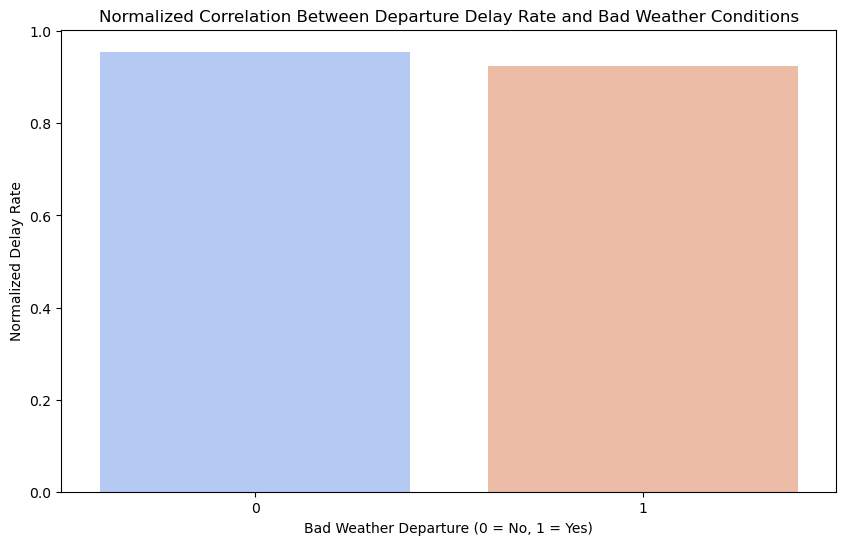

In [39]:
# Filter out rows with delays
df_departure = df.dropna(subset=['delay_in_minutes', 'BadWeatherDeparture'])

# Convert delay_in_minutes to a binary flag (1 if delay > 0, 0 otherwise)
df_departure['HasDelay'] = df_departure['delay_in_minutes'].apply(lambda x: 1 if x > 0 else 0)

# Group by bad weather condition and calculate the total number of flights and delays
flight_counts = df_departure.groupby('BadWeatherDeparture')['HasDelay'].count().reset_index(name='TotalFlights')
delay_counts = df_departure.groupby('BadWeatherDeparture')['HasDelay'].sum().reset_index(name='Delays')

# Merge the two DataFrames
merged_counts = pd.merge(delay_counts, flight_counts, on='BadWeatherDeparture')

# Calculate the normalized delay rate
merged_counts['NormalizedDelayRate'] = merged_counts['Delays'] / merged_counts['TotalFlights']

# Create a bar plot to show the normalized correlation
plt.figure(figsize=(10, 6))
sns.barplot(x='BadWeatherDeparture', y='NormalizedDelayRate', data=merged_counts, palette='coolwarm')

# Set plot title and labels
plt.title('Normalized Correlation Between Departure Delay Rate and Bad Weather Conditions')
plt.xlabel('Bad Weather Departure (0 = No, 1 = Yes)')
plt.ylabel('Normalized Delay Rate')

# Show plot
plt.show()


In [40]:
# Create a DataFrame that shows delays and bad weather conditions at departure and destination
delays_weather_df = df[['scheduled_time', 'departure_icao', 'arrival_icao', 'delay_in_minutes', 'BadWeatherDeparture', 'BadWeatherDestination']]

# Rename columns for clarity
delays_weather_df = delays_weather_df.rename(columns={
    'BadWeatherDeparture': 'BadWeather_Departure',
    'BadWeatherDestination': 'BadWeather_Destination'
})

# Display the table
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows (adjust as needed)
print(delays_weather_df)

# Alternatively, display the table as a sample output
delays_weather_df.head(10)


         scheduled_time departure_icao arrival_icao  delay_in_minutes  \
0   2025-01-09 17:30:00           kmco         kfll                17   
1   2025-01-09 12:30:00           kmco         kfll                17   
2   2025-01-09 17:00:00           kmco         kfll                48   
3   2025-01-01 06:25:00           kmco         kfll                12   
4   2025-01-01 16:15:00           kmco         kfll                15   
5   2025-01-01 20:33:00           kmco         kfll                11   
6   2025-01-02 06:00:00           kmco         kfll                 0   
7   2025-01-02 06:25:00           kmco         kfll                 9   
8   2025-01-02 10:50:00           kmco         kfll                 5   
9   2025-01-02 08:00:00           kmco         kfll                49   
10  2025-01-02 15:00:00           kmco         kfll                17   
11  2025-01-02 20:33:00           kmco         kfll                16   
12  2025-01-03 06:25:00           kmco         kfll

,scheduled_time,departure_icao,arrival_icao,delay_in_minutes,BadWeather_Departure,BadWeather_Destination
0,2025-01-09 17:30:00,kmco,kfll,17,0,1
1,2025-01-09 12:30:00,kmco,kfll,17,1,1
2,2025-01-09 17:00:00,kmco,kfll,48,0,1
3,2025-01-01 06:25:00,kmco,kfll,12,0,0
4,2025-01-01 16:15:00,kmco,kfll,15,0,1
5,2025-01-01 20:33:00,kmco,kfll,11,0,1
6,2025-01-02 06:00:00,kmco,kfll,0,1,1
7,2025-01-02 06:25:00,kmco,kfll,9,1,1
8,2025-01-02 10:50:00,kmco,kfll,5,1,1
9,2025-01-02 08:00:00,kmco,kfll,49,1,1


C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\595300902.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=both_ends_delay.index, y=both_ends_delay.values, palette='coolwarm')


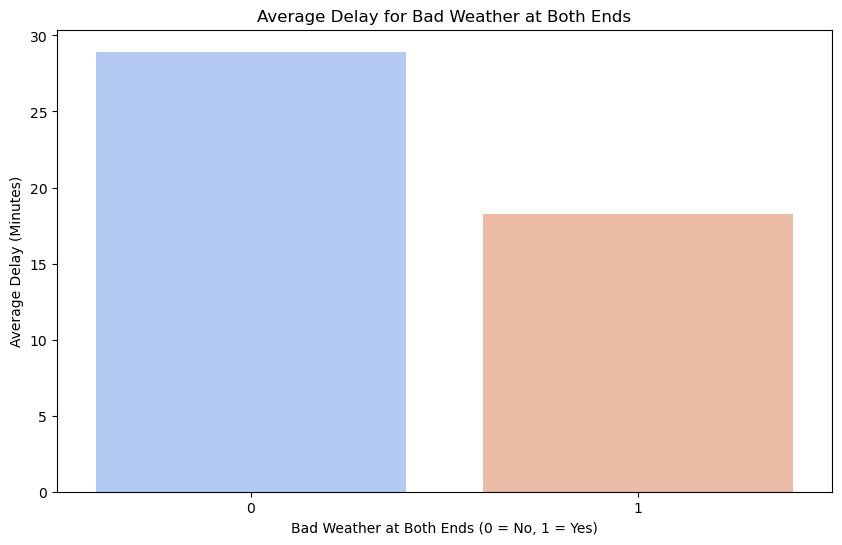

In [41]:
# Check the Correlation Between Departure and Destination Weather

# Create a new column for bad weather at both ends
df['BadWeatherBothEnds'] = (df['BadWeatherDeparture'] & df['BadWeatherDestination']).astype(int)

# Group by BadWeatherBothEnds and calculate average delay
both_ends_delay = df.groupby('BadWeatherBothEnds')['delay_in_minutes'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=both_ends_delay.index, y=both_ends_delay.values, palette='coolwarm')
plt.title('Average Delay for Bad Weather at Both Ends')
plt.xlabel('Bad Weather at Both Ends (0 = No, 1 = Yes)')
plt.ylabel('Average Delay (Minutes)')
plt.show()


C:\Users\Jean-Christophe\AppData\Local\Temp\ipykernel_9016\2003082943.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=either_ends_delay.index, y=either_ends_delay.values, palette=['blue', 'red'])


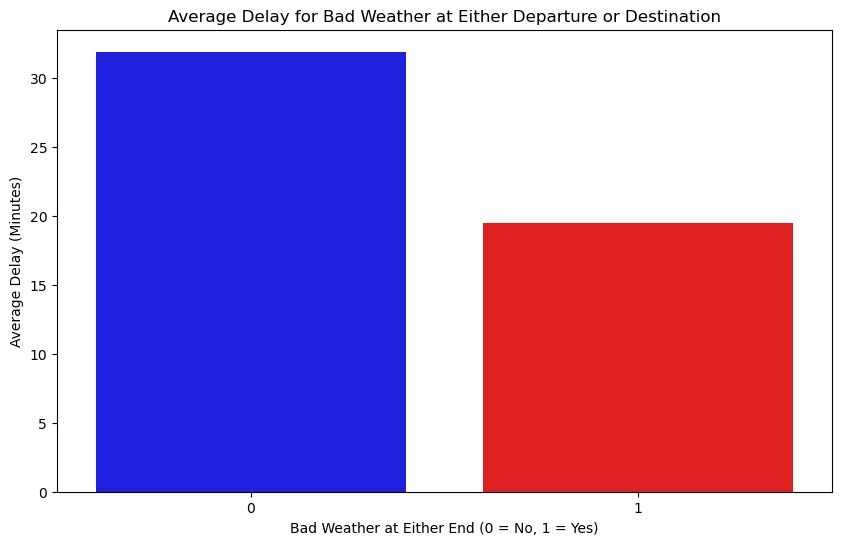

In [47]:
# Group by BadWeatherEither and calculate the average delay
either_ends_delay = df.groupby('BadWeatherEither')['delay_in_minutes'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=either_ends_delay.index, y=either_ends_delay.values, palette=['blue', 'red'])
plt.title('Average Delay for Bad Weather at Either Departure or Destination')
plt.xlabel('Bad Weather at Either End (0 = No, 1 = Yes)')
plt.ylabel('Average Delay (Minutes)')
plt.show()



BadWeatherEither           0          1
airline                                
aerolineas ejecutivas    NaN  17.000000
azul                   38.25  15.636364
copa airlines          38.25  15.636364
csi aviation             NaN  40.000000
delta air lines          NaN  41.000000
fedex                    NaN   0.000000
flightexec              0.00        NaN
fly alliance             NaN  48.000000
jetblue airways        39.00  17.500000
netjets aviation         NaN   8.500000
silver airways         32.60  17.214286
southwest airlines     14.00  22.857143
spirit airlines        23.75  21.645161
united airlines        38.25  15.636364


<Figure size 1400x800 with 0 Axes>

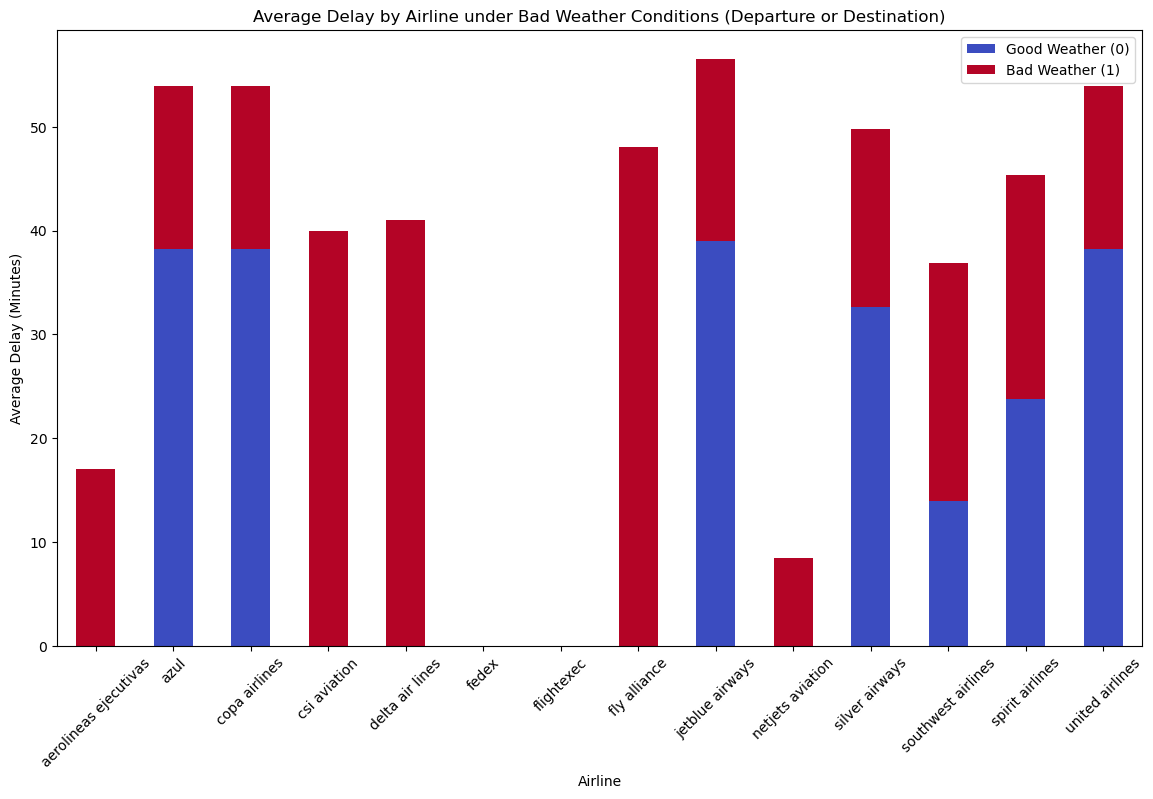

In [43]:
# Group by airline and BadWeatherEither to calculate the mean delay
airline_weather_impact = df.groupby(['airline', 'BadWeatherEither'])['delay_in_minutes'].mean().unstack()

# Display the DataFrame
print(airline_weather_impact)

# Plot the impact of bad weather on delays for each airline
plt.figure(figsize=(14, 8))
airline_weather_impact.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='coolwarm')
plt.title('Average Delay by Airline under Bad Weather Conditions (Departure or Destination)')
plt.xlabel('Airline')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.legend(['Good Weather (0)', 'Bad Weather (1)'])
plt.show()



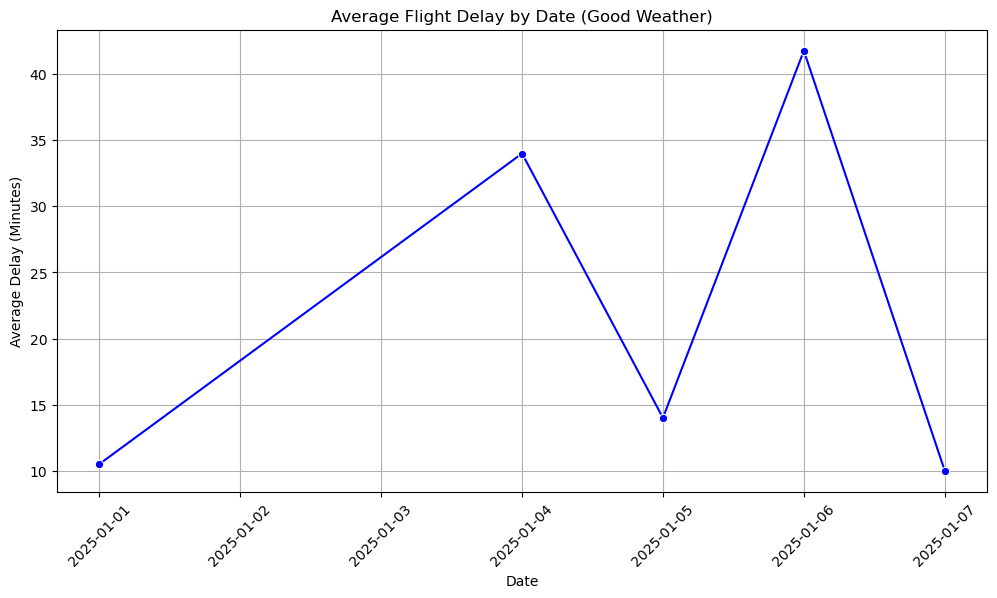

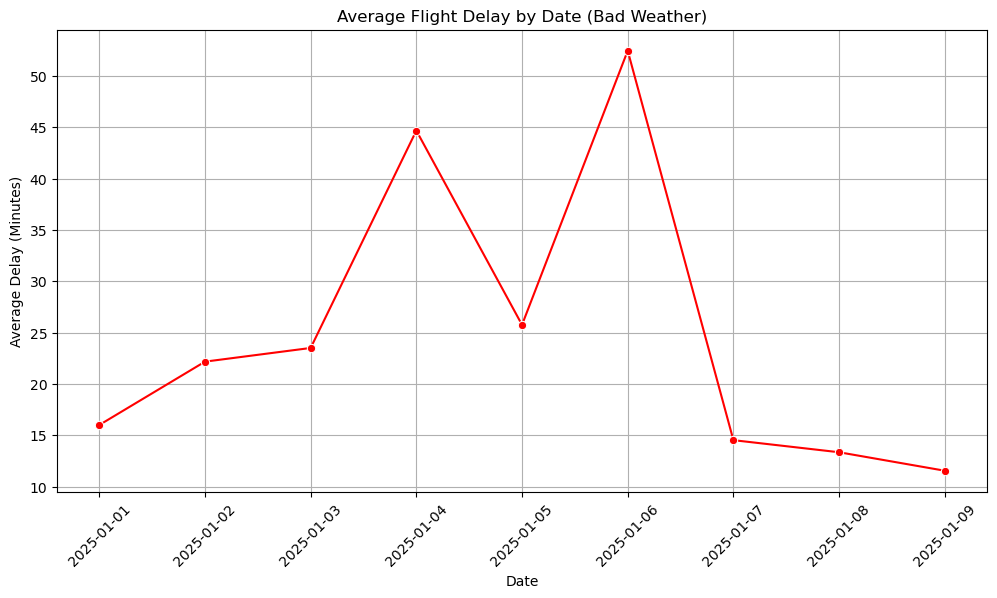

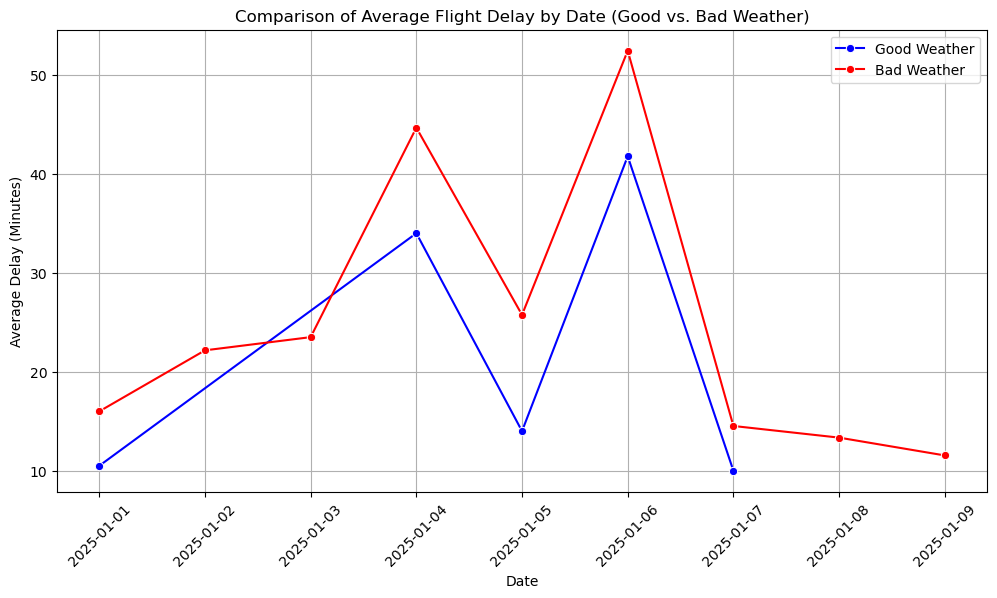

In [45]:
# --- Plot 1: Average Delay by Date for Good Weather ---
good_weather = df[df['BadWeatherEither'] == 0]
delays_by_date_good = good_weather.groupby('date')['delay_in_minutes'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=delays_by_date_good.index, y=delays_by_date_good.values, marker='o', color='b')
plt.title('Average Flight Delay by Date (Good Weather)')
plt.xlabel('Date')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# --- Plot 2: Average Delay by Date for Bad Weather ---
bad_weather = df[df['BadWeatherEither'] == 1]
delays_by_date_bad = bad_weather.groupby('date')['delay_in_minutes'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=delays_by_date_bad.index, y=delays_by_date_bad.values, marker='o', color='r')
plt.title('Average Flight Delay by Date (Bad Weather)')
plt.xlabel('Date')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# --- Plot 3: Comparison of Average Delays (Good Weather vs. Bad Weather) ---
plt.figure(figsize=(12, 6))
sns.lineplot(x=delays_by_date_good.index, y=delays_by_date_good.values, marker='o', label='Good Weather', color='b')
sns.lineplot(x=delays_by_date_bad.index, y=delays_by_date_bad.values, marker='o', label='Bad Weather', color='r')
plt.title('Comparison of Average Flight Delay by Date (Good vs. Bad Weather)')
plt.xlabel('Date')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
